In [1]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi

from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Audio


# used chatgpt to help me generate some functions

C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Processing the midi files
midi_files = glob('nes_midis/*')
print(len(midi_files))

config = TokenizerConfig(num_velocities=1)
tokenizer = REMI(config)
tokenizer.train(vocab_size = 2000, files_paths=midi_files)
pad_token = "PAD_None"

# Add if not already present
if pad_token not in tokenizer.vocab:
    tokenizer.add_to_vocab(pad_token)

# Retrieve its ID
pad_token_id = tokenizer[pad_token]

1975


In [3]:
from miditoolkit import MidiFile
midi_path = midi_files[0]
midi = MidiFile(midi_path)
tokens = tokenizer(midi)
print(tokens[0])

TokSequence(tokens=['Bar_None', 'Position_0', 'Pitch_65', 'Velocity_127', 'Duration_0.6.8', 'Position_6', 'Pitch_69', 'Velocity_127', 'Duration_0.2.8', 'Position_8', 'Pitch_65', 'Velocity_127', 'Duration_0.2.8', 'Position_10', 'Pitch_69', 'Velocity_127', 'Duration_0.2.8', 'Position_12', 'Pitch_70', 'Velocity_127', 'Duration_0.6.8', 'Position_18', 'Pitch_74', 'Velocity_127', 'Duration_0.2.8', 'Position_20', 'Pitch_70', 'Velocity_127', 'Duration_0.2.8', 'Position_22', 'Pitch_74', 'Velocity_127', 'Duration_0.2.8', 'Position_24', 'Pitch_77', 'Velocity_127', 'Duration_1.0.8'], ids=[381, 367, 754, 1333, 672, 54, 810, 909, 1295, 803, 976], bytes='%¿R~\x84ÅV~\x80ÇR~\x80ÉV~\x80ËW~\x84Ñ[~\x80ÓW~\x80Õ[~\x80×^~\x86', events=[Event(type=Bar, value=None, time=0, desc=0), Event(type=Position, value=0, time=0, desc=0), Event(type=Pitch, value=65, time=0, desc=6), Event(type=Velocity, value=127, time=0, desc=127), Event(type=Duration, value=0.6.8, time=0, desc=6 ticks), Event(type=Position, value=6, ti

C:\Users\Albert\AppData\Local\Temp\ipykernel_6892\1078242763.py:4: UserWarning: You are using a depreciated `miditoolkit.MidiFile` object. MidiTokis now (>v3.0.0) using symusic.Score as MIDI backend. Your file willbe converted on the fly, however please consider using symusic.
  tokens = tokenizer(midi)


In [4]:
instruments = {}
bad_files = []

for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        for instrument in midi.instruments:
            name = pretty_midi.program_to_instrument_name(instrument.program)
            instruments[name] = instruments.get(name, 0) + 1
    except Exception as e:
        bad_files.append(file)

print(instruments)


C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


{'Electric Guitar (jazz)': 124, 'Synth Brass 1': 123, 'Slap Bass 1': 112, 'Gunshot': 34, 'String Ensemble 1': 860, 'Harmonica': 22, 'Clarinet': 216, 'Acoustic Bass': 253, 'Trumpet': 214, 'Acoustic Grand Piano': 1613, 'Brass Section': 185, 'Fretless Bass': 168, 'Distortion Guitar': 238, 'Contrabass': 195, 'String Ensemble 2': 175, 'Orchestral Harp': 205, 'Flute': 176, 'Choir Aahs': 124, 'Timpani': 100, 'Reverse Cymbal': 17, 'Clavinet': 115, 'Piccolo': 65, 'French Horn': 106, 'Electric Grand Piano': 95, 'Tuba': 70, 'FX 4 (atmosphere)': 88, 'Pad 3 (polysynth)': 66, 'Pad 2 (warm)': 30, 'FX 1 (rain)': 30, 'FX 8 (sci-fi)': 25, 'Orchestra Hit': 60, 'Lead 1 (square)': 947, 'Lead 2 (sawtooth)': 530, 'Overdriven Guitar': 213, 'Pizzicato Strings': 114, 'Synth Bass 2': 114, 'Marimba': 57, 'Electric Bass (pick)': 201, 'Lead 3 (calliope)': 34, 'Lead 4 chiff': 20, 'Recorder': 55, 'Violin': 115, 'Acoustic Guitar (steel)': 164, 'Synth Strings 2': 32, 'Synth Bass 1': 131, 'Acoustic Guitar (nylon)': 187,

<h1>Basic Exploratory Data Analysis

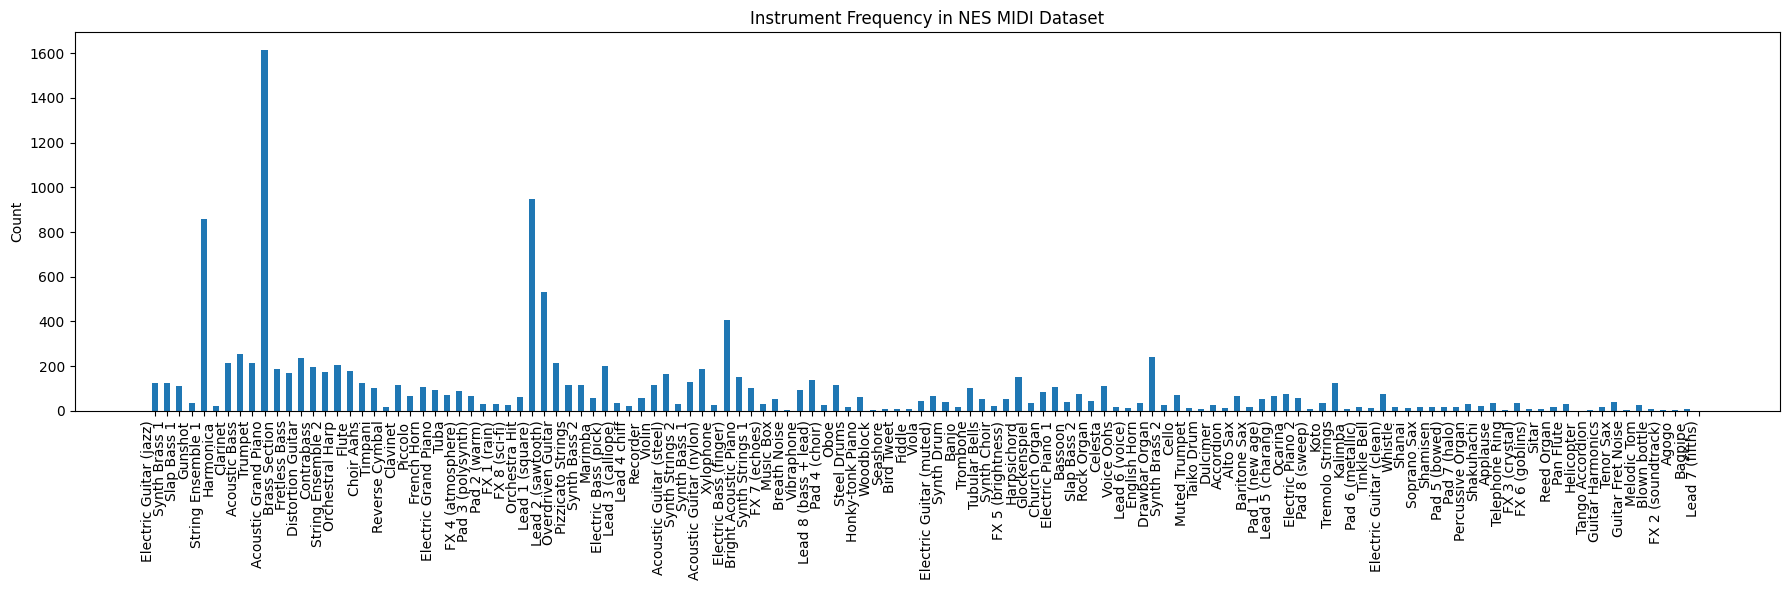

In [5]:
#Bar Graph showing total instrument count

names = list(instruments.keys())
counts = list(instruments.values())

plt.figure(figsize=(18, 6)) 
plt.bar(names, counts, width = .5)
plt.xticks(rotation=90, ha='right') 
plt.title("Instrument Frequency in NES MIDI Dataset")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [6]:
##Gives a note count per file and lists off the top 5 files with most notes
notes_per_file = []

for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        note_count = sum(len(instrument.notes) for instrument in midi.instruments)
        notes_per_file.append((file, note_count))
    except:
        continue

sorted(notes_per_file, key=lambda x: x[1], reverse=True)[:5]

[('nes_midis\\826_DoubleDragon-Stage1.mid', 35843),
 ('nes_midis\\1047_town4.mid', 23816),
 ('nes_midis\\1194_T_FinalFantasy_MatoyaTheme_ShiningRemix.mid', 20122),
 ('nes_midis\\723_contra.mid', 18274),
 ('nes_midis\\1016_dq4_fight.mid', 18146)]

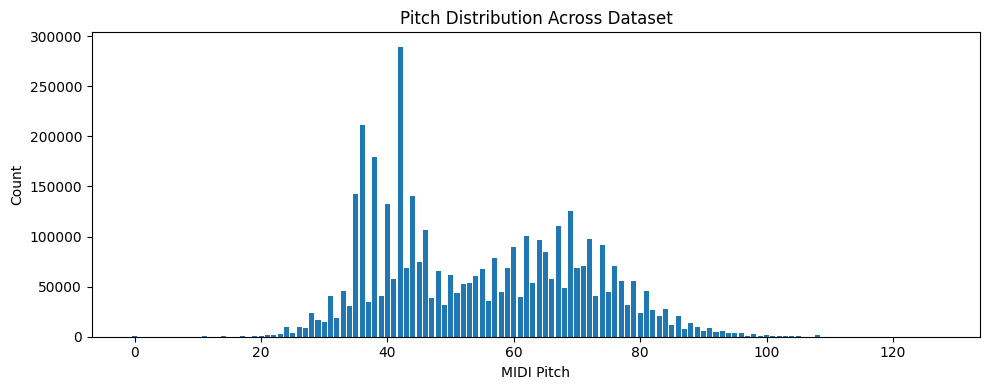

In [7]:
## Pitch Distribution Across Dataset

all_pitches = []
for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        for inst in midi.instruments:
            all_pitches.extend([note.pitch for note in inst.notes])
    except:
        continue

pitch_counts = Counter(all_pitches)

plt.figure(figsize=(10,4))
plt.bar(pitch_counts.keys(), pitch_counts.values())
plt.xlabel('MIDI Pitch')
plt.ylabel('Count')
plt.title('Pitch Distribution Across Dataset')
plt.tight_layout()
plt.show()

<h1> Baseline Model(s)

In [4]:
def note_extraction(midi_file):
    try:
        score = Score(midi_file)
    except Exception as e:
        print(f"Failed to parse {midi_file}: {e}")
        return []

    pitches = []
    for track in score.tracks:
        for note in track.notes:
            pitches.append(note.pitch)
    return pitches

In [5]:
#pairwise probabilities containing p(next_note | previous_note) values for the dataset
def note_bigram_probability(midi_files):
    bigramTransitions = defaultdict(list)
    bigramTransitionProbabilities = defaultdict(list)
    for file in midi_files:
        notes = note_extraction(file)
        for i in range(len(notes)-1):
            prev_note = notes[i]
            next_note = notes[i+1]
            bigramTransitions[prev_note].append(next_note)

    for prev_note,next_notes in bigramTransitions.items():
        total = len(next_notes)
        next_note_counts = defaultdict(int) ## dictionary to keep track of how many times a note comes after prev_note
        for note in next_notes:
            next_note_counts[note] += 1
        sorted_next_notes = list(next_note_counts.keys())
        probabilities = [next_note_counts[n] / total for n in sorted_next_notes]
        bigramTransitions[prev_note] = sorted_next_notes
        bigramTransitionProbabilities[prev_note] = probabilities
    return bigramTransitions, bigramTransitionProbabilities

In [6]:
## I believe we can calculate a perplexity score for transformers as well so we can compare perplexity scores as way of evaluation
def note_frequency(midi_files):
    pitch_counts = {}
    for file in midi_files:
        notes = note_extraction(file)
        for note in notes:
            if note in pitch_counts:
                pitch_counts[note] += 1
            else:
                pitch_counts[note] = 1
    return pitch_counts

def note_unigram_probability(midi_files):
    note_counts = note_frequency(midi_files)
    unigramProbabilities = {}
    total_notes = sum(note_counts.values())
    for note,count in note_counts.items():
        unigramProbabilities[note] = count / total_notes
    return unigramProbabilities
    
def note_bigram_perplexity(midi_file, unigramProbabilities, bigramTransitions, bigramTransitionProbabilities):
    notes = note_extraction(midi_file)
    if not notes:
        return float('inf')  # or skip

    log_sum = 0
    first_note = notes[0]
    prob = unigramProbabilities.get(first_note, 1e-10)
    log_sum += np.log(prob)

    for i in range(1, len(notes)):
        prev_note = notes[i - 1]
        current_note = notes[i]
        prob = unigramProbabilities.get(current_note, 1e-10)  # fallback

        if prev_note in bigramTransitions:
            next_notes = bigramTransitions[prev_note]
            probs = bigramTransitionProbabilities[prev_note]
            if current_note in next_notes:
                index = next_notes.index(current_note)
                prob = probs[index]

        log_sum += np.log(prob)

    avg_log = log_sum / len(notes)
    perplexity = np.exp(-avg_log)
    return perplexity


In [7]:
transitions, transition_probs = note_bigram_probability(midi_files)

In [8]:
def generate_sequence(transitions, transition_probs, start_note, length=50):
    sequence = [start_note]
    current_note = start_note
    for _ in range(length - 1):
        if current_note not in transitions:
            break 
        next_notes = transitions[current_note]
        probs = transition_probs[current_note]
        next_note = random.choices(next_notes, weights=probs)[0]
        sequence.append(next_note)
        current_note = next_note
    return sequence

In [9]:
start_note = random.choice(list(transitions.keys()))
generated_notes = generate_sequence(transitions, transition_probs, start_note, length=100)

In [10]:
def notes_to_midi(note_sequence, filename="bigram_output.mid"):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    start = 0
    duration = 0.5  # constant duration
    for pitch in note_sequence:
        note = pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=start+duration)
        instrument.notes.append(note)
        start += duration
    midi.instruments.append(instrument)
    midi.write(filename)

notes_to_midi(generated_notes)

In [11]:
def average_bigram_perplexity(midi_files):
    perplexities = []

    # Precompute once
    unigramProbabilities = note_unigram_probability(midi_files)
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(midi_files)

    for file in midi_files:
        try:
            perp = note_bigram_perplexity(
                file,
                unigramProbabilities,
                bigramTransitions,
                bigramTransitionProbabilities
            )
            if not np.isnan(perp) and not np.isinf(perp):
                perplexities.append(perp)
        except Exception as e:
            print(f"Failed to compute perplexity for {file}: {e}")

    if len(perplexities) == 0:
        return None
    return sum(perplexities) / len(perplexities)


In [12]:
print(average_bigram_perplexity(midi_files))

19.96284011242286


Once the file is written above, you can have the music be played on this website:
https://pianotify.com/import-midi-file

<h1>Transformer Model

In [13]:
import os
import miditoolkit

midi_folder = 'nes_midis'  # Change to your actual folder path

for filename in os.listdir(midi_folder):
    if filename.endswith('.mid'):
        filepath = os.path.join(midi_folder, filename)
        try:
            _ = miditoolkit.MidiFile(filepath)  # Try to load MIDI
        except Exception as e:
            print(f"Corrupt or unreadable MIDI file found and will be deleted: {filename}")
            os.remove(filepath)

In [14]:
# List of cleaned valid .mid file paths
midi_files = [
    os.path.join(midi_folder, f)
    for f in os.listdir(midi_folder)
    if f.endswith('.mid')
]

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from tqdm import tqdm
import miditok
import miditoolkit
from torch.optim.lr_scheduler import CosineAnnealingLR

# Transformer model for music token sequences
class MusicTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=512,
        nhead=8,
        num_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        max_seq_length=1024
    ):
        super(MusicTransformer, self).__init__()
        
        # Token and position embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_length, d_model))
        
        # 🔥 New: LayerNorm after input embeddings
        self.input_layernorm = nn.LayerNorm(d_model)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection to vocabulary
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        seq_len = x.size(1)
        
        # Embed tokens and add position embeddings
        x = self.token_embedding(x) + self.pos_embedding[:, :seq_len, :]
        
        # 🔥 Apply LayerNorm after embeddings
        x = self.input_layernorm(x)
        
        # Pass through Transformer
        x = self.transformer(x)
        
        # Project to logits
        logits = self.output_layer(x)
        return logits

class MidiTokenDataset(Dataset):
    def __init__(self, tokenizer, midi_files, max_seq_len=512):
        self.samples = []
        self.tokenizer = tokenizer
        
        valid_files = []
        for filepath in tqdm(midi_files):
            try:
                # Load midi to check if valid
                midi_obj = miditoolkit.MidiFile(filepath)
                valid_files.append(filepath)
            except Exception as e:
                print(f"Failed to process {filepath}: {e}")
                os.remove(filepath)
        
        # Now tokenize and prepare samples
        for filepath in tqdm(valid_files):
            try:
                midi_obj = miditoolkit.MidiFile(filepath)
                tokseq = tokenizer(midi_obj)[0]  # ✅ take first TokSequence
                ids = tokseq.ids
                ids = ids[:max_seq_len]
                if len(ids) > 10:
                    self.samples.append(torch.tensor(ids, dtype=torch.long))
                else:
                    print(f"Sample too short in {filepath} — length {len(ids)}")
            except Exception as e:
                print(f"Failed to tokenize {filepath}: {e}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

def compute_token_weights(dataset, vocab_size):
    token_counts = Counter()
    for sample in dataset:
        token_counts.update(sample.tolist())

    counts = np.zeros(vocab_size, dtype=np.float32)
    for token_id, count in token_counts.items():
        counts[token_id] = count

    counts += 1e-6  # avoid zeros
    
    weights = 1.0 / counts
    weights = weights / np.max(weights)  # normalize max to 1
    
    return torch.tensor(weights, dtype=torch.float)
    
# Custom collate function to pad sequences in a batch
def pad_collate(batch):
    return pad_sequence(batch, batch_first=True, padding_value=pad_token_id)
    
# Training function for one epoch
def train(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch[:, :-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), batch[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 👈 important
        optimizer.step()
        total_loss += loss.item()
    if scheduler:
        scheduler.step()
    return total_loss / len(dataloader)

# Generate tokens autoregressively from model
def generate_music(model, tokenizer, max_length=512, temperature=1.0, top_k=50, device='cuda'):
    model.eval()
    idx = [random.choice(list(tokenizer.vocab.values()))]  # random start token
    
    with torch.no_grad():
        for _ in range(max_length):
            input_ids = torch.tensor(idx, dtype=torch.long).unsqueeze(0).to(device)
            logits = model(input_ids)[:, -1, :] / temperature

            # Top-k sampling
            topk_values, topk_indices = torch.topk(logits, top_k)
            probs = torch.softmax(topk_values, dim=-1)
            next_token = topk_indices[0][torch.multinomial(probs, num_samples=1)]
            
            idx.append(next_token.item())
    
    return idx

# Convert tokens to a MIDI file using tokenizer's decode + symusic
def tokens_to_midi(token_ids, tokenizer, output_path='output.mid'):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.cpu().tolist()
    
    # Create TokSequence from token IDs
    tok_seq = miditok.TokSequence(ids=token_ids)
    
    # Decode expects a list of TokSequence objects
    score = tokenizer.decode([tok_seq])
    
    # Save as MIDI
    score.dump_midi(output_path)
    print(f"Saved generated MIDI to {output_path}")

from torch.nn.utils.rnn import pad_sequence


    
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Your list of midi file paths
    #midi_files = [...]  # <-- put your .mid file paths here
    
    # Load REMI tokenizer
    tokenizer = miditok.REMI()
    
    # Ensure pad token exists, otherwise add one
    pad_token_id = 0
    
    # Prepare dataset and dataloader
    dataset = MidiTokenDataset(tokenizer, midi_files, max_seq_len=512)
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        shuffle=True,
        drop_last=True,
        collate_fn=pad_collate
    )
    
    # Compute token weights for weighted loss
    weights = compute_token_weights(dataset, vocab_size=len(tokenizer.vocab))
    
    # Initialize model
    model = MusicTransformer(vocab_size=len(tokenizer.vocab), max_seq_length=512).to(device)
    
    # Optimizer, weighted loss, scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss(weight=weights.to(device), ignore_index=pad_token_id)
    scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    
    # Training for multiple epochs
    num_epochs = 5
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        loss = train(model, dataloader, optimizer, criterion, device, scheduler)
        print(f"Training loss: {loss:.4f}")
    
    # Generate music tokens
    print("Generating music...")
    token_ids = generate_music(model, tokenizer, max_length=512, temperature=1.0, device=device)
    
    # Convert tokens to MIDI
    tokens_to_midi(token_ids, tokenizer, output_path='transformer_output.mid')

  0%|                                                                                         | 0/1975 [00:00<?, ?it/s]C:\Users\Albert\AppData\Local\Temp\ipykernel_6892\789932019.py:80: UserWarning: You are using a depreciated `miditoolkit.MidiFile` object. MidiTokis now (>v3.0.0) using symusic.Score as MIDI backend. Your file willbe converted on the fly, however please consider using symusic.
  tokseq = tokenizer(midi_obj)[0]  # ✅ take first TokSequence
 62%|████████████████████████████████████████████████▋                             | 1234/1975 [01:17<00:43, 16.97it/s]

Sample too short in nes_midis\247_The_Map_-_Face_your_destiny.mid — length 10


 74%|█████████████████████████████████████████████████████████▉                    | 1466/1975 [01:36<00:25, 20.19it/s]

Sample too short in nes_midis\485_t_cast~1.mid — length 7


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1943/1975 [02:17<00:01, 19.74it/s]

Sample too short in nes_midis\961_The_prince_and_princess.mid — length 5


100%|██████████████████████████████████████████████████████████████████████████████| 1975/1975 [02:20<00:00, 14.09it/s]


Epoch 1/5


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:15<00:00,  7.95it/s]


Training loss: 5.2310
Epoch 2/5


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:14<00:00,  8.35it/s]


Training loss: 4.0005
Epoch 3/5


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:14<00:00,  8.34it/s]


Training loss: 3.2707
Epoch 4/5


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:14<00:00,  8.34it/s]


Training loss: 2.8695
Epoch 5/5


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:14<00:00,  8.32it/s]


Training loss: 2.5729
Generating music...
Saved generated MIDI to transformer_output.mid
